# Setup

In [1]:
from twins_embedding import TwinsEmbeddingAnalysis
from matplotlib import pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from idrtools import math
from utils import frac_to_mag
import utils

/home/kyle/supernova/snfactory/manifold_twins/analysis/twins_embedding.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
%matplotlib inline

In [3]:
a = TwinsEmbeddingAnalysis()
a.settings['figure_directory'] = './output_generation/figures/'
a.settings['latex_directory'] = './output_generation/latex/'
a.run_analysis()

Loading dataset...
    IDR:          BLACKSTON
    Phase range: [-5.0, 5.0] days
    Bin velocity: 1000.0



Estimating the spectra at maximum light...
    Loaded cached stan model
    Using saved stan result
Reading between the lines...
    Loaded cached stan model
    Using saved stan result
Building masks...
    Masking 30/203 targets whose uncertainty power is 
    more than 0.100 of the intrinsic power.
Generating the manifold learning embedding...
Loading other indicators of diversity...
Fitting RBTL Twins Manifold GP...
GP magnitude residuals fit:
    Fit result:           b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
    intrinsic_dispersion      0.073 ± 0.008
    gp_kernel_amplitude       0.164 ± 0.082
    gp_length_scale           5.541 ± 3.315
    offset                    -0.116 ± 0.124
    covariate_slope_0         -0.122 ± 0.051
    Fit NMAD                  0.083 mag
    Fit std                   0.101 mag
Fitting SALT2 Twins Manifold GP...
GP magnitude residuals fit:
    Fit result:           b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
    intrinsic_dispersion    

# Fit GPs for each number of components

In [4]:
from manifold_gp import ManifoldGaussianProcess

In [5]:
all_gps = []
for num_components in tqdm(range(10)):
    gps = []
    embedding = a.generate_embedding(num_components=num_components+1)
    for i in tqdm(range(len(a.wave))):
        gp = ManifoldGaussianProcess(a, embedding, a.fractional_differences[:, i], a.fractional_difference_uncertainties[:, i], mask=a.uncertainty_mask)
        gp.fit(verbosity=-1)
        gps.append(gp)
    all_gps.append(gps)

/home/kyle/supernova/snfactory/manifold_twins/analysis/manifold_gp.py:168: RuntimeWarning: invalid value encountered in sqrt
  self.parameter_uncertainties = np.sqrt(np.diag(cov))


/home/kyle/supernova/snfactory/manifold_twins/analysis/manifold_gp.py:168: RuntimeWarning: invalid value encountered in sqrt
  self.parameter_uncertainties = np.sqrt(np.diag(cov))


/home/kyle/supernova/snfactory/manifold_twins/analysis/manifold_gp.py:168: RuntimeWarning: invalid value encountered in sqrt
  self.parameter_uncertainties = np.sqrt(np.diag(cov))


/home/kyle/supernova/snfactory/manifold_twins/analysis/manifold_gp.py:168: RuntimeWarning: invalid value encountered in sqrt
  self.parameter_uncertainties = np.sqrt(np.diag(cov))


/home/kyle/supernova/snfactory/manifold_twins/analysis/manifold_gp.py:168: RuntimeWarning: invalid value encountered in sqrt
  self.parameter_uncertainties = np.sqrt(np.diag(cov))


/home/kyle/supernova/snfactory/manifold_twins/analysis/manifold_gp.py:168: RuntimeWarning: invalid value encountered in sqrt
  self.parameter_uncertainties = np.sqrt(np.diag(cov))


/home/kyle/supernova/snfactory/manifold_twins/analysis/manifold_gp.py:168: RuntimeWarning: invalid value encountered in sqrt
  self.parameter_uncertainties = np.sqrt(np.diag(cov))


/home/kyle/supernova/snfactory/manifold_twins/analysis/manifold_gp.py:168: RuntimeWarning: invalid value encountered in sqrt
  self.parameter_uncertainties = np.sqrt(np.diag(cov))


/home/kyle/supernova/snfactory/manifold_twins/analysis/manifold_gp.py:168: RuntimeWarning: invalid value encountered in sqrt
  self.parameter_uncertainties = np.sqrt(np.diag(cov))


/home/kyle/supernova/snfactory/manifold_twins/analysis/manifold_gp.py:168: RuntimeWarning: invalid value encountered in sqrt
  self.parameter_uncertainties = np.sqrt(np.diag(cov))


# Intrinsic dispersion vs wavelength

In [6]:
int_disps = np.array([[j.parameter_dict['intrinsic_dispersion'] for j in i] for i in all_gps])

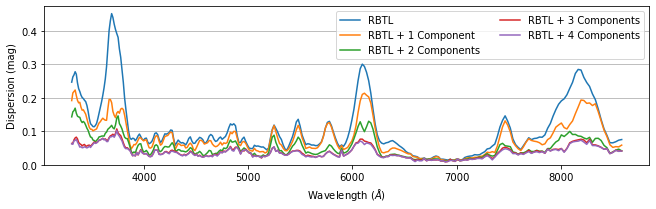

In [184]:
fig, ax = plt.subplots(figsize=a.settings['spectrum_plot_figsize'])

ax.plot(a.wave, utils.frac_to_mag(a.rbtl_result['fractional_dispersion']), label='RBTL')

for i in range(4):
    ax.plot(a.wave, utils.frac_to_mag(int_disps[i]), label=f"RBTL + {i+1} Component{'s' if i > 0 else ''}")

ax.legend(ncol=2)
ax.set_xlabel(a.settings['spectrum_plot_xlabel'])
ax.set_ylabel('Dispersion (mag)')
ax.set_ylim(0, None)
ax.grid(axis='y')
a.savefig('isomap_gp_dispersions.pdf')

# Fraction of variance explained

In [8]:
from sklearn.decomposition import PCA
pca = PCA(10)
pca_embedding = pca.fit_transform(a.fractional_differences[a.uncertainty_mask])

In [182]:
# Calculate unexplained dispersion with both Isomap + GP and PCA
ref_unexplained_variance = np.sum(a.rbtl_result['fractional_dispersion']**2)
noise_variance = np.mean(np.sum(a.fractional_difference_uncertainties[a.uncertainty_mask]**2, axis=1))

unexplained_variance_isomap_gp = np.sum(int_disps**2, axis=1) + noise_variance
unexplained_variance_pca = ref_unexplained_variance - np.cumsum(pca.explained_variance_)

ratio_isomap_gp = 1 - unexplained_variance_isomap_gp / ref_unexplained_variance
ratio_pca = 1 - unexplained_variance_pca / ref_unexplained_variance
ratio_noise_variance = noise_variance / ref_unexplained_variance

In [ ]:
import matplotlib
matplotlib.set_loglevel

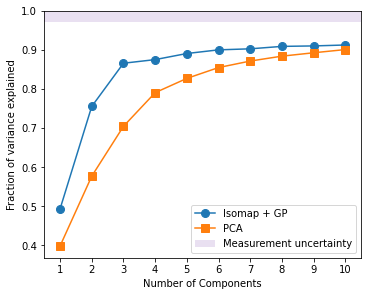

In [209]:
plt.figure(figsize=(5., 4.))
xvals = np.arange(10) + 1
plt.plot(xvals, ratio_isomap_gp, label='Isomap + GP', marker='o', markersize=8)
plt.plot(xvals, ratio_pca, label='PCA', marker='s', markersize=8)
plt.xlabel('Number of Components')
plt.ylabel('Fraction of variance explained')
plt.fill_between([0, 11], 1 - ratio_noise_variance, 1., facecolor='C4', alpha=0.2, ls='--', label='Measurement uncertainty')
plt.ylim(None, 1.)
plt.xlim(0.5, 10.5)
plt.xticks(xvals)
plt.legend()
a.savefig('explained_variance_comparison.pdf')

# Leave-one-out predictions

In [11]:
predictions = []
for component_gps in tqdm(all_gps):
    component_predictions = []
    for gp in tqdm(component_gps):
        component_predictions.append(gp.predict_out_of_sample())
    predictions.append(component_predictions)
predictions = np.array(predictions)

In [170]:
%matplotlib inline

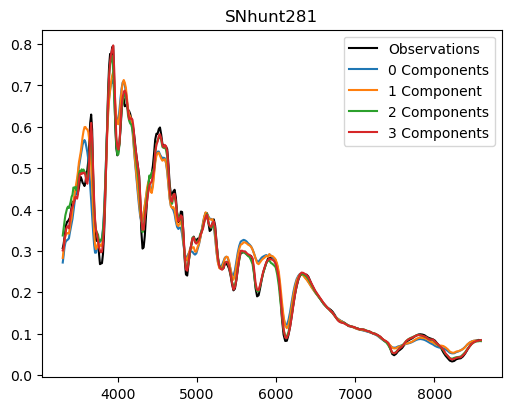

In [171]:
plt.figure(figsize=(5, 4), dpi=100)

idx = 200

plt.plot(a.wave, a.scale_flux[idx], c='k', label='Observations')

plt.plot(a.wave, a.mean_flux, label='0 Components')

for num_components in range(3):
    plt.plot(a.wave, a.mean_flux * (1 + predictions[num_components, :, 0, idx]),
             label=f'{num_components + 1} Component{"s" if num_components > 0 else ""}')

plt.title(a.targets[idx].name)
plt.legend()

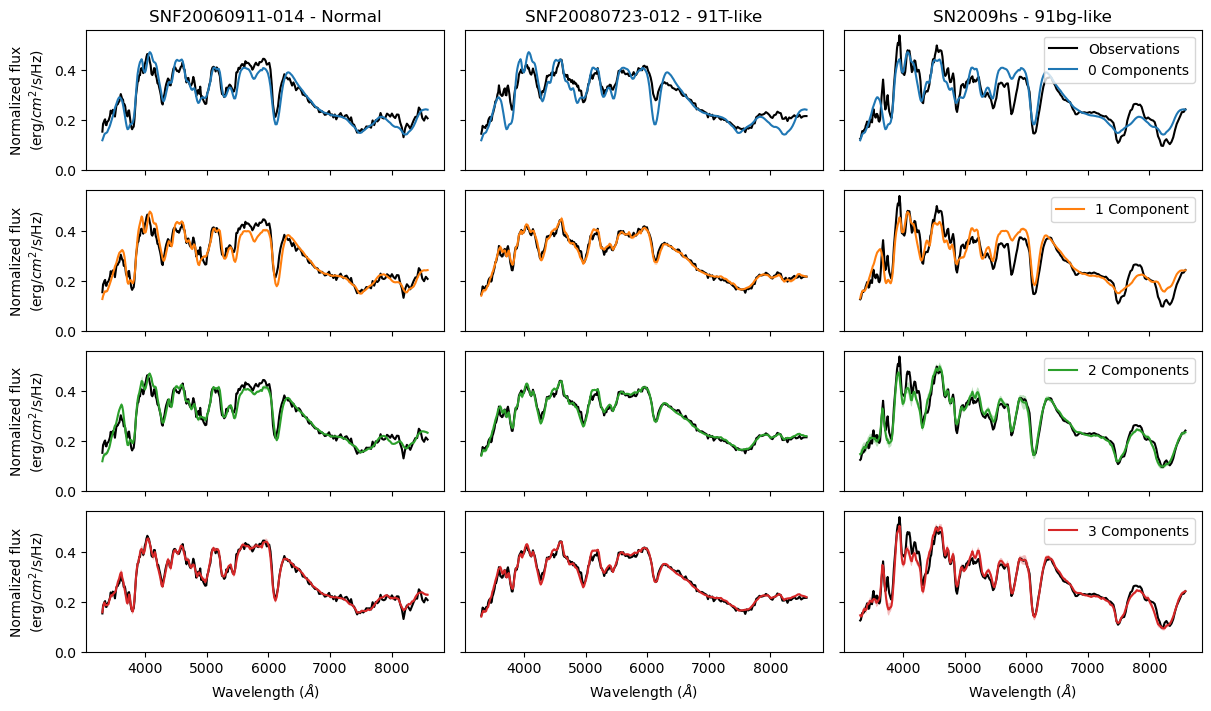

In [190]:
max_num_components = 3
indices = [112, 167, 86]

fig, axes = plt.subplots(max_num_components + 1, len(indices), sharex=True, sharey=True, figsize=(12, 7), dpi=100)

for num_components, ax_rows in enumerate(axes):
    for i, ax in enumerate(ax_rows):
        idx = indices[i]
        
        if num_components == 0:
            a.plot_flux(ax, a.scale_flux[idx], c='k', label='Observations')
            a.plot_flux(ax, a.mean_flux, label='0 Components')
            #ax.plot(a.wave, a.scale_flux[idx], c='k', label='Observations')
            #ax.plot(a.wave, a.mean_flux, label='0 Components')
            ax.set_title(f'{a.targets[idx].name} - {a.indicators[idx]["peculiar_type"]}')
        else:
            pred = a.mean_flux * (1 + predictions[num_components - 1, :, 0, idx])
            pred_err = a.mean_flux * predictions[num_components - 1, :, 1, idx]

            a.plot_flux(ax, a.scale_flux[idx], c='k')
            a.plot_flux(ax, pred, pred_err, c=f'C{num_components}', label=f'{num_components} Component{"s" if num_components > 1 else ""}')
            
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.get_legend().remove()

for ax in axes[-1]:
    ax.set_xlabel('Wavelength ($\AA$)')

for i, ax in enumerate(axes[:, -1]):
    ax.legend(loc=1)
    
for i, ax in enumerate(axes[:, 0]):
    ax.set_ylabel(a.settings['spectrum_plot_ylabel'])
    
a.savefig('reconstructed_spectra.pdf', fig)

# Correlation matrices

In [218]:
plt.cm.coolwarm(1)

(0.23437707945098038, 0.3055417303294118, 0.7596795275882353, 1.0)

In [229]:
# Make a colormap that highlights edges
x = np.linspace(-1, 1, 100)
y = np.sign(x) * x**2 / 2 + 0.5
from matplotlib.colors import ListedColormap
cmap = ListedColormap(plt.cm.coolwarm(y))

def plot_correlation(num_components):
    residuals = a.fractional_differences[a.uncertainty_mask]
    
    if num_components > 0:
        residuals = residuals - predictions[num_components - 1, :, 0, a.uncertainty_mask]
    
    fig, ax = plt.subplots()
    plt.imshow(np.corrcoef(residuals.T), vmin=-1, vmax=1, cmap=cmap, origin='lower')
    plt.colorbar(label='Pearson Correlation')

    # Figure out where to put ticks
    tick_locs = [4000, 5000, 6000, 7000, 8000]
    tick_idx = np.interp(tick_locs, a.wave, np.arange(len(a.wave)))
    plt.xticks(tick_idx, tick_locs)
    plt.yticks(tick_idx, tick_locs)
    plt.xlabel(a.settings['spectrum_plot_xlabel'])
    plt.ylabel(a.settings['spectrum_plot_xlabel'])
    
    plt.title(f"RBTL + {num_components} Component{'s' if num_components != 1 else ''}")
    
    a.savefig(f'correlation_{num_components}_components.pdf')

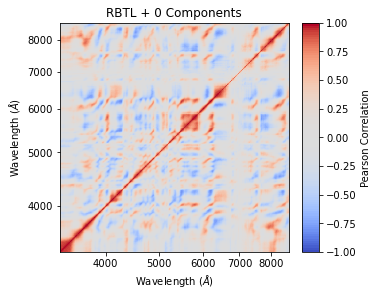

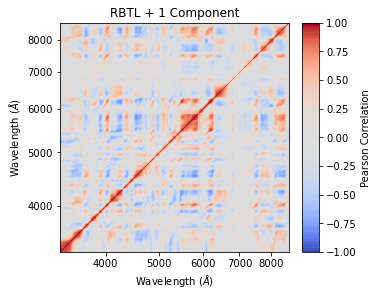

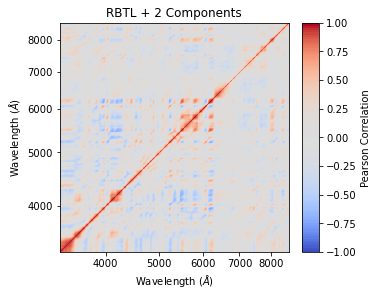

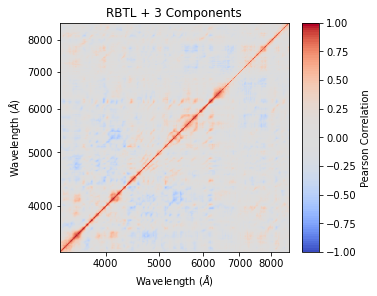

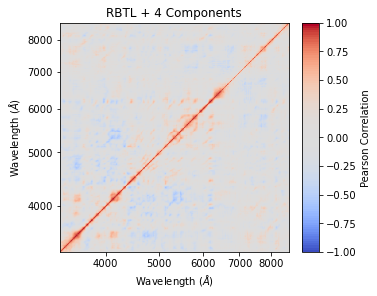

In [230]:
for num_components in range(5):
    plot_correlation(num_components)

# Latex macros

In [205]:
with a.latex_open('explained_variance.tex') as f:
    utils.latex_command(f, 'isomapgpexpvarfulli', '%.1f', 100 * ratio_isomap_gp[0])
    utils.latex_command(f, 'isomapgpexpvarfullii', '%.1f', 100 * ratio_isomap_gp[1])
    utils.latex_command(f, 'isomapgpexpvarfulliii', '%.1f', 100 * ratio_isomap_gp[2])
    utils.latex_command(f, 'isomapgpexpvarfulliv', '%.1f', 100 * ratio_isomap_gp[3])

    utils.latex_command(f, 'isomapgpexpvari', '%.1f', 100 * ratio_isomap_gp[0] / (1 - ratio_noise_variance))
    utils.latex_command(f, 'isomapgpexpvarii', '%.1f', 100 * ratio_isomap_gp[1] / (1 - ratio_noise_variance))
    utils.latex_command(f, 'isomapgpexpvariii', '%.1f', 100 * ratio_isomap_gp[2] / (1 - ratio_noise_variance))
    utils.latex_command(f, 'isomapgpexpvariv', '%.1f', 100 * ratio_isomap_gp[3] / (1 - ratio_noise_variance))

    utils.latex_command(f, 'isomapgpexpvarindivi', '%.1f', 100 * ratio_isomap_gp[0])
    utils.latex_command(f, 'isomapgpexpvarindivii', '%.1f', 100 * (ratio_isomap_gp[1] - ratio_isomap_gp[0]))
    utils.latex_command(f, 'isomapgpexpvarindiviii', '%.1f', 100 * (ratio_isomap_gp[2] - ratio_isomap_gp[1]))
    utils.latex_command(f, 'isomapgpexpvarindiviv', '%.1f', 100 * (ratio_isomap_gp[3] - ratio_isomap_gp[2]))
    
    utils.latex_command(f, 'isomapgpnoise', '%.1f', 100 * ratio_noise_variance)

\newcommand{\isomapgpexpvarfulli}{49.3}
\newcommand{\isomapgpexpvarfullii}{75.5}
\newcommand{\isomapgpexpvarfulliii}{86.6}
\newcommand{\isomapgpexpvarfulliv}{87.5}
\newcommand{\isomapgpexpvari}{50.8}
\newcommand{\isomapgpexpvarii}{77.8}
\newcommand{\isomapgpexpvariii}{89.2}
\newcommand{\isomapgpexpvariv}{90.1}
\newcommand{\isomapgpexpvarindivi}{49.3}
\newcommand{\isomapgpexpvarindivii}{26.2}
\newcommand{\isomapgpexpvarindiviii}{11.1}
\newcommand{\isomapgpexpvarindiviv}{0.9}
\newcommand{\isomapgpnoise}{2.9}
